<a href="https://colab.research.google.com/github/tiwarylab/TERP/blob/main/TERP_tabular_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone TERP repository

In [1]:
!npx degit -f tiwarylab/TERP

npx: installed 1 in 2.146s
> destination directory is not empty. Using --force, continuing
> cloned tiwarylab/TERP#HEAD


Create synthetic data with 10 input features with (0,4,7) feature indices with relative weights (2,5,-1) being relevant for the prediction function

In [152]:
import numpy as np
import matplotlib.pyplot as plt

######################################
np.random.seed(0)
total_input_features = 10
dataset_size = 20000
relevant_indices = [0,4,7] ## Final TERP result should identify these feature indices as relevant with weights specified in the following line of code
relevant_weights = [3,5,-2]
#######################################

input = np.random.uniform(-5,10,(dataset_size,total_input_features))

def prediction(inp_data):
  data = inp_data[:, relevant_indices]
  ## Add small noise to prediction
  eps = np.random.normal(0,0.05,(data.shape[0],1))
  predict = np.zeros((data.shape[0]))
  for i in range(predict.shape[0]):
   temp = 0
   for j in range(len(relevant_indices)):
    temp += data[i,j]*relevant_weights[j]
   predict[i] = temp + eps[i]
  return predict

Save synthetic data as a numpy array

In [153]:
np.save('input_data.npy', input)

TERP step 1: Neighborhood data generation (10000 perturbed samples) to explain prediction for input index 0 (first sample in the synthetic dataset)

In [154]:
!python TERP_neighborhood_generator.py -seed 0 --progress_bar -input_numeric input_data.npy -num_samples 10000 -index 0

>>> Numerical data provided...
>>> Generating data...
100% 10000/10000 [00:00<00:00, 37132.55it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA


Save prediction for the neighborhood generated in step 1 as a numpy array

In [155]:
pred_1 = prediction(np.load('DATA/make_prediction_numeric.npy'))
np.save('DATA/neighborhood_state_probabilities.npy', pred_1)
print(np.load('DATA/TERP_numeric.npy').shape, pred_1.shape)

(10000, 10) (10000,)


TERP step 2: Initial round of linear regression (useful for discarding irrelevant features when high number of input features are present in the dataset)

In [156]:
!python TERP_optimizer_01.py -TERP_input DATA/TERP_numeric.npy -blackbox_prediction DATA/neighborhood_state_probabilities.npy

----------------------------------------------------------------------------------------------------
11-17-23 19:48:52 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
10000 (10000, 10)
11-17-23 19:48:52 initialization  INFO     Input data read successful ...
11-17-23 19:48:52 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-17-23 19:48:52 initialization  WARNING  Cutoff not provided. Defaulting to :: 25
11-17-23 19:48:52 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-17-23 19:48:52 initialization  WARNING  Top 25 features selected with weight coverage :: 1.0000000000000002!!
11-17-23 19:48:52 initialization  INFO     Selected the following 10 out of (10) features to form a feature sub-space ::
11-17-23 19:48:52 initialization  INFO     [4, 0, 7, 5, 3, 1, 8,

TERP step 3: Neighborhood regeneration (10000 samples) by perturbing a subset of relevant features identified in step 2

In [157]:
!python TERP_neighborhood_generator.py -seed 0 --progress_bar -input_numeric input_data.npy -num_samples 10000 -index 0 -selected_features TERP_results/selected_features.npy

>>> Numerical data provided...
>>> Generating data...
100% 10000/10000 [00:00<00:00, 38965.67it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA_2


Save prediction for the neighborhood generated in step 3 as a numpy array

In [158]:
pred_2 = prediction(np.load('DATA_2/make_prediction_numeric.npy'))
np.save('DATA_2/neighborhood_state_probabilities.npy', pred_2)
print(np.load('DATA_2/TERP_numeric.npy').shape, pred_2.shape)

(10000, 10) (10000,)


TERP step 4: Implementing forward feature selection to identify most relevant features

In [159]:
!python TERP_optimizer_02.py -TERP_input DATA_2/TERP_numeric.npy -blackbox_prediction DATA_2/neighborhood_state_probabilities.npy -selected_features TERP_results/selected_features.npy

----------------------------------------------------------------------------------------------------
11-17-23 19:48:54 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
11-17-23 19:48:54 initialization  INFO     Input data read successful ...
11-17-23 19:48:54 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-17-23 19:48:54 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-17-23 19:48:54 initialization  INFO     Feature selection results read successful!
11-17-23 19:48:54 initialization  INFO     Similarity computation complete...
----------------------------------------------------------------------------------------------------
Number of models constructed:: 100% 10/10 [00:02<00:00,  4.92it/s]
11-17-23 19:48:56 TERP_SGD_step_02 INFO     Analysis complete! Compu

Load final TERP result and plot the relative weights

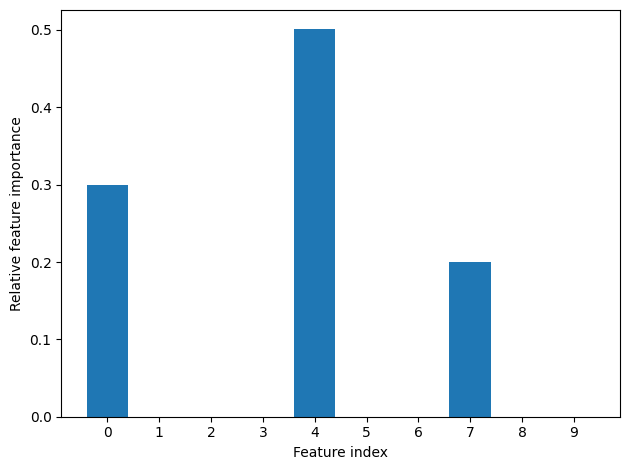

In [160]:
w = np.load('TERP_results_2/optimal_feature_weights.npy')
fig, ax = plt.subplots()
ax.bar(np.arange(w.shape[0]), w)
ax.set_xticks(np.arange(w.shape[0]))
ax.set_xlabel(r'Feature index')
ax.set_ylabel('Relative feature importance')
fig.tight_layout()

TERP successfully created a sparse interpretation with the relevant features